# FarmChallenge

## Model Description 
This intially constructs the 3D (homogeneous) steady state box model that you built for your BoxModel_Manual assignment

#### Dimensions: 
- 25 by 25 by 1
- dx = dy = 100 m
- dz = 600 m  

#### Subsurface Properties: 
- Heterogenous with 4 main zones of high Ks and low Ks  
- Porosity = 0.35
- Specific yield = 0.3
- Storage coefficient=0.001  

#### Boundary Conditions: 
 - Right boundary is constant head of 595 m relative to the datum, which is located at the bottom of the domain.  
 - Left boundary is a constant head of 550 m relative to the datum, which is located at the bottom of the domain. 

## 1. Setup the environment

In [91]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 

## 2. Create the model object

In [92]:
modelname = "FarmChallenge"
moddir = "C:/Users/acero/OneDrive/Desktop/groundwater_modeling/homework-jlhubbell88/mf2005"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)
#moddir = os.getcwd()+"\\modflowdir\\mf2005.exe"


In [93]:
#optional delete old run files
run = 'n'
if run == 'y':
    file_extensions = ['.dis','.bas','.lpf','.oc','.pcg','.wel']
    #file_extensions = ['.dis','.bas','.bcf','.oc','.pcg', '.wel', 'rch']
    for ext in file_extensions:
        os.remove(modelname + ext)

## 3. Setup the discretization (DIS package)

For more details on DIS package inputs refer to : https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfdis.html 

#### 3.1 Spatial discretization

In [94]:
nrow = 25 #number of rows
ncol = 25 #number of columns
nlay = 1  #number of layers

dx= 100 #width of grid cells in x direction 
dy= 100 #width of grid cells in y direction 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y
ztop = 600.    #top elevation 
zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction

print(dz)

600.0


#### 3.2 Temporal discretization 

In [95]:
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

#### 3.3 Create DIS object

In [96]:
#create flopy discretization object, length and time are meters (2) and days (4)
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

#### 3.4 Plot the grid

For help on this function see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.plot.plotutil.html

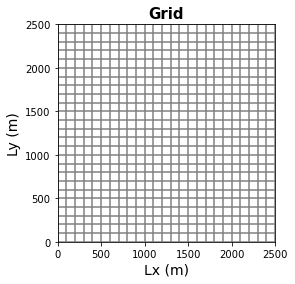

In [97]:
#use flopy to plot the grid of model 'm'
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid() 
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Grid', fontsize = 15, fontweight = 'bold')
plt.show()

## 4. Setup constant head boundaries, active cells and initial heads (BAS Package)

For more details on the BAS package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfbas.html

#### 4.1 Define cell activity: IBOUND 

In [98]:
#create ibound as array of ints = 1
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active     

#set constant head boundary on the left
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 
ibound[:,:,-1] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 

#print("ibound values: \n", ibound)

#### 4.2 Define starting heads 

In [99]:
#setup initial heads as 1 everywhere and 7 on the left boundary 
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_left = 595 # Left boundary constant head value
H_right = 550  # Right boundary constant head value
H_init[:, :, 0] = H_left  # replace first (left) col with desired head value
H_init[:, :, -1] = H_right  # replace first (left) col with desired head value

#print("starting head val ues: \n", H_init)


#### 4.3 Create BAS object

In [100]:
#create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#### 4.4 Plot the grid and ibound

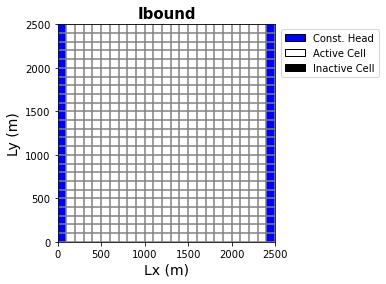

In [101]:
#plot grid and ibound
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)

## 5. Setup Layer Properties (LPF or BCF packages)

There are two packages that can be used for the **LPF** and **BCF**. They are very similar but have some different options for layer types and controling connections between layers. 

- For more details on LPF package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mflpf.html
- For more details on BCF package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfbcf.html
  
Note that both are setup below but only one is actually being called. 

#### 5.1 Set layer properties
Setting up arrays for the K field and they layer type

**NOTE: Layer type options differ between the LPF anc BCF packages**

In [102]:
K_vals = np.zeros((nlay, nrow, ncol))
K_vals[:,0:14,0:14] = 1.5   # upper left
K_vals[:,0:14,13:26] = 1.0   # upper right 
K_vals[:,13:26,0:14] = 13.0   # lower left 
K_vals[:,13:26,13:26] = 8.4   # lower right


K_vert = 1     #Either the value of hvertical K or the ratio of horizontal to vertical K (refer to documentation_)

n = 0.35        #assign porosity
Ss = 0.001      #assign storage coefficient
Sy = 0.3        #assign specific yield
laytype = 1       #0=confined, >0 = convertible (for the LPF file)


#### 5.2 Plot the K field

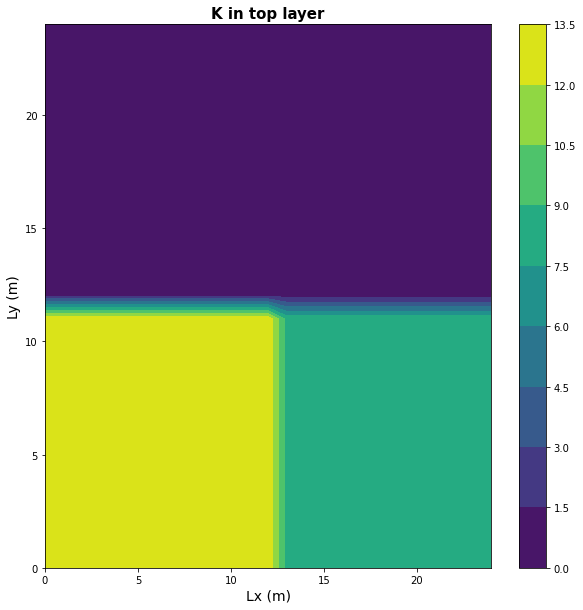

In [103]:
#plot K values in top layer
fig1 = plt.figure(figsize=(10, 10))  # create 10 x 10 figure
plt.xlabel('Lx (m)', fontsize=14)
plt.ylabel('Ly (m)', fontsize=14)
plt.title('K in top layer', fontsize=15, fontweight='bold')
plt.contourf(np.flipud(K_vals[0, :, :]))
plt.colorbar()
plt.show()

#### 5.3a  Make LPF object

In [104]:
#assigns horizontal and vertical Ks and saves cell-by-cell budget data
lpf = flopy.modflow.ModflowLpf(m, laytyp=laytype, hk=K_vals, 
                                vka=K_vert, ss=Ss,
                                sy=Sy,storagecoefficient=True, ipakcb=53) 


#### 5.3.b Make BCF object

In [105]:
#assigns horizontal and vertical Ks and saves cell-by-cell budget data
#bcf = flopy.modflow.ModflowBcf(m, ipakcb=53, intercellt=0, laycon=3, trpy=1.0, hdry=-1e+30, iwdflg=0, wetfct=0.1, iwetit=1, ihdwet=0, tran=1.0, hy=K_vals[0,:,:], vcont=1.0, sf1=Ss, sf2=Sy, wetdry=-0.01, extension='bcf', unitnumber=None, filenames=None) 


## 6. Setup outputs by stress period (OC Package)
For more details on OC Package: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfoc.html

#### 6.1 Setup outputs

In [106]:
#create oc stress period data. 
#(0,0) tells OC package to save data for stress period 1, time step 1.
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 

print("oc stress period data: \n", spd)

oc stress period data: 
 {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}


#### 6.2 Make OC object 

In [107]:
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

## 7. Set the numerical solver (PCG Package)

We are using the Preconditioned Conjugate Gradient package:

Additionally, MODFLOW online describes these solvers: https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?oc.htm

And Flopy documents its communication with the PCG MODFLOW package: http://modflowpy.github.io/flopydoc/mfpcg.html

#### 7.1 Make the PCG object

In [108]:
pcg = flopy.modflow.ModflowPcg(model=m)

## 8. Add wells for the constant flux boundary (WEL Package)
For more details on the WEL package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfwel.html

#### 8.1 Setup the well parameters (use this to set a defined flux boundary)

In [124]:
#well 1 on wildcat farm

Q_in1 = -350                        #pumping well on wildcat farm at 0,0 coordinates (m3/day)
fluxes1 = [0,8,2,Q_in1]

sp_fluxes = {0: fluxes1}              #create a dictionary with entries for each stress period

#well 1 on ACME farm


Q_in2 = -5231                         #pumping well on ACME farm at 0,0 coordinates  (m3/day)
fluxes2 = [0,23,7,Q_in2]

sp_fluxes = {0: [fluxes1, fluxes2]}              #create a dictionary with entries for each stress period

#well 2 on ACME farm


Q_in3 = -5231                      #pumping well on ACME farm at second location within farm boundaries (NW corner)  (m3/day)
fluxes3 = [0,23,9,Q_in3]

sp_fluxes = {0: [fluxes1, fluxes2,fluxes3]}              #create a dictionary with entries for each stress period

print(sp_fluxes)



{0: [[0, 8, 2, -350], [0, 23, 7, -5231], [0, 23, 9, -5231]]}


#### 8.2 Make the WEL object

In [110]:
wel = flopy.modflow.mfwel.ModflowWel(m, stress_period_data=sp_fluxes)  #create object for WEL package

## 9. Add recharge (RCH Package)

For more details on the recharge package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfrch.html

#### 9.1 Setup recharge value

In [111]:
#Recharge 
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
bkgd_recharge = 1e-4                    #m/day
wc_recharge = 0
acme_recharge = 0

rech_zone[:,:] = bkgd_recharge
rech_zone[7:10,1:4] = wc_recharge
rech_zone[5:25,7:17] = acme_recharge

rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     #create rch object


#### 9.2 Add evapotranspiration
For more details on the evapotranspiraiton package see the flopy and modflow documentation: 
- https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfevt.html 
- https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?evt.htm 
- https://pubs.usgs.gov/tm/2005/tm6A16/PDF.htm (refer to chapter 6)



In [112]:
#ET for background of model
ET_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
bkgndET = 0 #5e-5                         #set background ET value m/day
ET_zone= ET_zone + bkgndET                       

extinction_depth = 0

#ET
#ET_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
#wildcatET = 2e-6                         #set background ET value m/day
#ET_zone[15:18,2:5] = wildcatET           #apply background ET to wildcat farm 

#extinction_depth = 3
#extinction depth is the depth where if our water table is below that, our ET will be ZERO #between surface and extinction depth is just a linear interpolation

#ET
#ET_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
#ACMEET = 1e-7                          #set background ET value m/day
#ET_zone[0:20,7:17] = ACMEET           #apply background ET to ACME farm =200 grid cells

#extinction_depth = 8
#extinction depth is the depth where if our water table is below that, our ET will be ZERO
evt = flopy.modflow.mfevt.ModflowEvt(model=m, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) #ipakcb makes sure it applies to water balance of all cells, default is 0, 53 is a safe integer to choose, some are taken 


## 10. Write inputs and run the model 

#### 10.1 Write Inputs

In [113]:
m.write_input()    #uses the package objects created above to actually write the text files, 
                    #and saves to folder that this script is in
                    #after this step you should see the files appear in your folder


#### 10.2 Run the model

In [114]:
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: C:/Users/acero/OneDrive/Desktop/groundwater_modeling/homework-jlhubbell88/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: FarmChallenge.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/03/18 10:04:22

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/03/18 10:04:22
 Elapsed run time:  0.096 Seconds

  Normal termination of simulation


## 11. Plot the results  

#### 11.1 Read in the model outputs

For information on binary files see: http://modflowpy.github.io/flopydoc/binaryfile.html 

For information on flow budget files see: 
http://modflowpy.github.io/flopydoc/binaryfile.html#flopy.utils.binaryfile.CellBudgetFile

##### Read the heads 

In [115]:
headobj = bf.HeadFile(modelname+'.hds')    #reads the binary head file
times = headobj.get_times()                #returns a list of timesteps
head = headobj.get_data(totim=times[-1])        #returns a numpy array of heads for specified time (last timestep)

#print('timesteps:', times)         
#print('final head:', 'dimensions', np.shape(head), '\n', head)    
#print('initial head:', 'dimensions', np.shape(H_init), '\n', H_init)
#print('well fluxes:', 'dimensions', np.shape(fluxes), '\n', fluxes)

##### Write Heads as csv

In [116]:
with open('FP_heads.csv', 'w', newline='') as csvfile:  #creates an empty csv file called FP_heads
    writer = csv.writer(csvfile, delimiter=',')        
    for i in range(len(head[0,:,0])):                    #writes each row
        writer.writerow(head[0,i,:])


### Read the Water balance and get the heads, ET and Recharge

In [117]:
budgobj = bf.CellBudgetFile(modelname+'.cbc')  # reads the cell budget file
kstpkper_list = budgobj.get_kstpkper() #returns a list of stress periods & timesteps
#dummy = budgobj.list_records()


#Get the ET from the cell budget files
et = budgobj.get_data(text='et', totim=1.0)
et_vals = np.squeeze(et)[1,:,:] #This is a matrix of the ET fluxes [m3/day]
et_tot= np.sum(et_vals)
print("Total ET [m3/day]:", et_tot) #This is the total ET flux across the domain

#Get the recharge from the cell budget files
recharge = budgobj.get_data(text='recharge', totim=1.0)
recharge_vals = np.squeeze(recharge)[1,:,:] #This is a matrix of the recharge fluxes [m3/day]
rch_tot = np.sum(recharge_vals)
print("Total Recharge [m3/day]:", rch_tot)  # This is the total recharge flux across the domain


# Get the flow rates on the cell right and front faces
frf = budgobj.get_data(text='flow right face', totim=1.0)
fff = budgobj.get_data(text='flow front face', totim=1.0)
flux_vals = np.squeeze(frf)
leftflux = np.round(flux_vals[:, 0], 4)
rightflux = np.round(flux_vals[:, -2], 4)

# Calculate the total flux across the right and left side of the domain
right_tot = np.sum(rightflux)  # Note the units of this are L3/T
left_tot = np.sum(leftflux)

print('Left Flux[m3/day] =', left_tot, " Right_flux[m3/day]=", right_tot)

print('The water balance is qin + recharge - ET - pumping well - qout = zero, this means mass is conserved in the system.')
#print('left_flux+recharge-Qout(Well)-ET-right_flux=',left_tot + rch_tot + et_tot - right_tot + Q_in)
print("extinction depth for ET=",extinction_depth)

Total ET [m3/day]: 0.0
Total Recharge [m3/day]: 366.0
Left Flux[m3/day] = 147626.94  Right_flux[m3/day]= 147644.94
The water balance is qin + recharge - ET - pumping well - qout = zero, this means mass is conserved in the system.
extinction depth for ET= 0


### Plot ET Rcharge and WTD

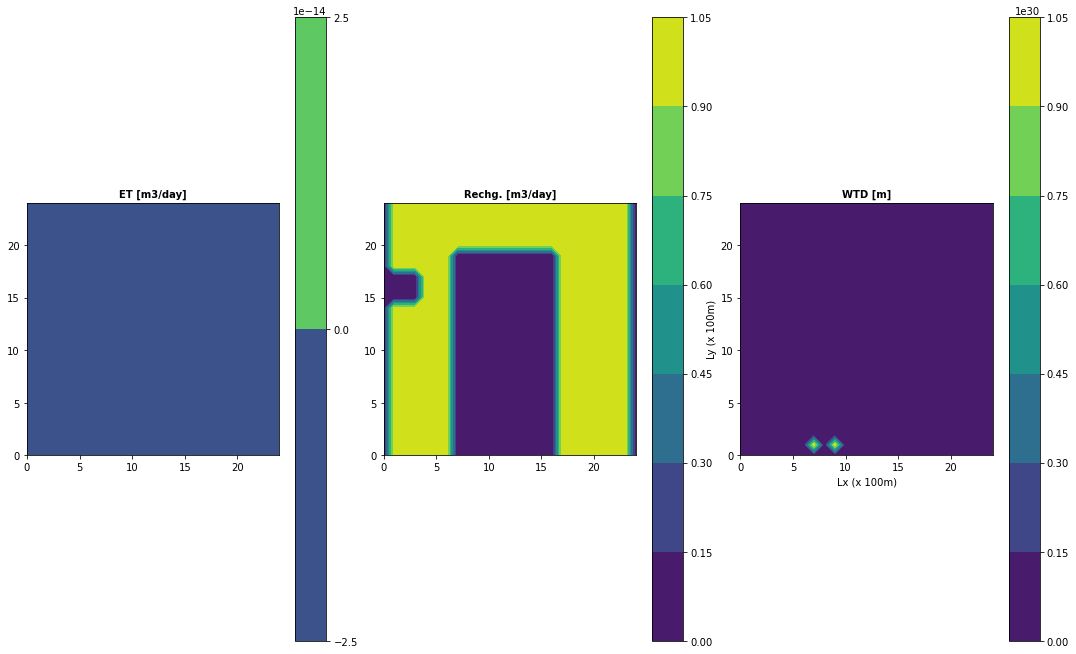

In [118]:
#Plot ET, Recharge and WTD
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (15,15))
fig.tight_layout(pad=1.0)

#ET
#ax1.set_xlabel('Lx (m)', fontsize=10)
#ax1.set_ylabel('Ly (m)', fontsize=10)
ax1.set_title('ET [m3/day]', fontsize=10, fontweight='bold')
etplot = ax1.contourf(np.flipud(et_vals))
fig.colorbar(etplot, ax=ax1, shrink=0.6)
ax1.set_aspect('equal')

#Recharge
#ax2.set_xlabel('Lx (m)', fontsize=10)
#ax2.set_ylabel('Ly (m)', fontsize=10)
ax2.set_title('Rechg. [m3/day]', fontsize=10, fontweight='bold')
rchplot = ax2.contourf(np.flipud(recharge_vals))
fig.colorbar(rchplot, ax=ax2, shrink=0.6)
ax2.set_aspect('equal')


#WTD
#Calcualte WTD at the domain thickness (ztop) minus the head
WTD = ztop-head
ax3.set_xlabel('Lx (x 100m)', fontsize=10)
ax3.set_ylabel('Ly (x 100m)', fontsize=10)
ax3.set_title('WTD [m]', fontsize=10, fontweight='bold')
wtdplot = ax3.contourf(np.flipud(WTD[0,:,:]))
fig.colorbar(wtdplot, ax=ax3, shrink=0.6)
ax3.set_aspect('equal')

plt.show()


### Plot the boundary flows

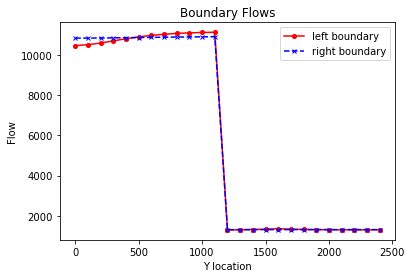

Left Flow = 147626.94  Right Flow = 147644.94  Difference = 18.0


In [119]:
bdryflux_fig = plt.figure() 
ylocs=np.arange(0,ncol*dy, dy) 
plt.plot(ylocs, np.flip(leftflux),marker='o', color='red', markersize=4, linestyle='-',label="left boundary")
plt.plot(ylocs, np.flip(rightflux),marker='x', color='blue', markersize=4, linestyle='--',label="right boundary")
plt.xlabel('Y location')
plt.ylabel('Flow')
plt.title("Boundary Flows")
plt.legend()
plt.show()

# Calculate the total flux across the right and left side of the domain 
# See that the difference matches the pumping rate
right_tot = np.sum(rightflux) #Note the units of this are L3/T
left_tot = np.sum(leftflux)

print('Left Flow =', left_tot, " Right Flow =", right_tot, " Difference =", right_tot-left_tot)

#### 11.2 Evaluate the head gradients

Head Gradient 0.018 m/m


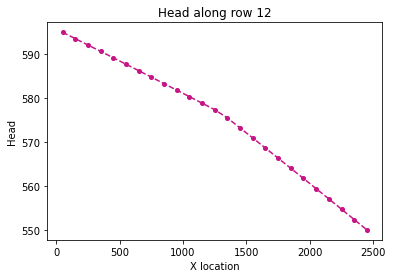

In [120]:
head_fig = plt.figure() 
xcenters=np.arange(dx/2,ncol*dx,dx) 
headplot=head[0,12,:]
plt.plot(xcenters,headplot,marker='o', color='mediumvioletred', markersize=4, linestyle='--')
plt.xlabel('X location')
plt.ylabel('Head')
plt.title("Head along row 12")
#plt.axvline(x=1200)

#Save figure
# plt.savefig('Head_Transect.png') #save figure as a png

hgrad=(head[0,5,0]-head[0,5,-1])/Lx
print("Head Gradient", hgrad, "m/m") 


#### 11.3 3D plot of heads

C:\Users\acero\AppData\Local\Temp/ipykernel_5828/1678668645.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig_3d.gca(projection='3d')


Text(0.5, 0.92, 'Steady-State Model Head Profile')

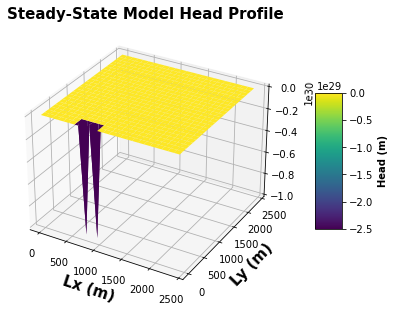

In [121]:
#create 3d figure
fig_3d = plt.figure(figsize=(12,5))
ax = fig_3d.gca(projection='3d')

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(head[0])

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('Steady-State Model Head Profile', fontsize=15, fontweight='bold')
# plt.savefig('BoxModel_Surface1.png') 
#plt.show(surf)

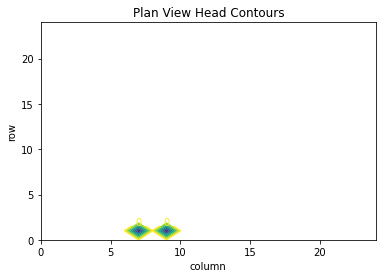

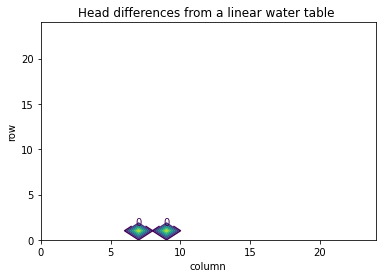

In [122]:
#create 2d figure - note, axes relate to well being defined as layer, row, column, flux
CS=plt.contour(np.flipud(head[0]))
plt.xlabel("column")
plt.ylabel("row")
plt.title("Plan View Head Contours")
plt.clabel(CS, inline=1, fontsize=10)
plt.show()

# calculate linear head drop (no pumping)
bkgnd_head=np.linspace(H_left,H_right,ncol)
bkgnd_head=np.tile(bkgnd_head,(ncol,1))
CS=plt.contour(np.flipud(bkgnd_head-head[0]))
plt.xlabel("column")
plt.ylabel("row")
plt.title("Head differences from a linear water table ")
plt.clabel(CS, inline=1, fontsize=10)
plt.show()


####  11.4 Contour Head plot

C:\Users\acero\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\acero\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(


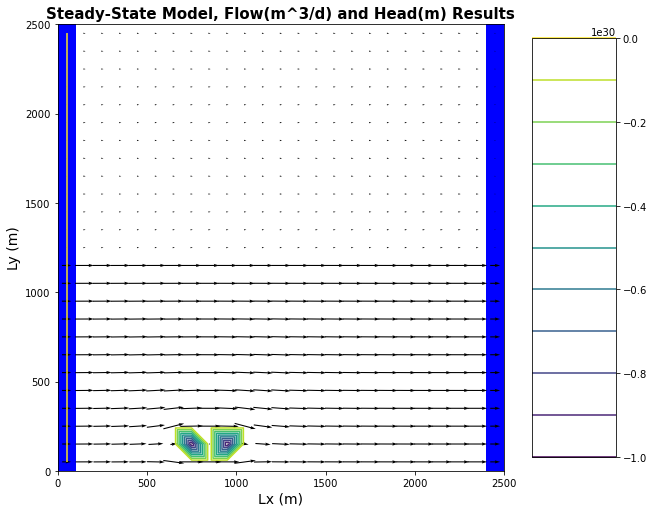

In [123]:
#plot first contour plot
fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head[0].min(),head[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf[0], fff[0], head=head) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Steady-State Model, Flow(m^3/d) and Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
# plt.savefig('BoxModel_vectors.png')   
#plt.show(modelmap)